In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec

In [2]:
#paths + global variables
subs = ['sub-01','sub-02', 'sub-03','sub-04', 'sub-05', 'sub-06']
ft_models = ['conv4', 'conv5', 'conv6', 'conv7', 'no']
atlas = ['wholebrain', 'STG']
baseline = 'no'

csv_paths_sub236 = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/metrics.csv'
csv_path_sub145 = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/metrics_145.csv'
csv_path_leaderboard = '/home/maelle/GitHub_repositories/cNeuromod_encoding_2020/benchmark/HEAR-EVAL/leaderboard.csv'

In [3]:
def list_positions_in_matrix2D(nb_rows, nb_col):
    i_rows = np.repeat(np.arange(nb_rows), nb_col)
    i_col = np.tile(np.arange(nb_col), nb_rows)
    pos = [(row, col) for row, col in zip(i_rows, i_col)]
    return pos

In [4]:
#dataframe with difference in accuracy with baseline (no_ft) in reference 
def diff_df(df, subs, atlas):
    all_diff_df = pd.DataFrame([], columns=df.columns)
    for sub in subs:
        for a in atlas:
            selected_df = df.loc[(df['subject'] == sub) & (df['atlas'] == a)]
            subject_serie = selected_df.pop('subject').reset_index()
            atlas_serie = selected_df.pop('atlas').reset_index()
            finetune_serie = selected_df.pop('finetune').reset_index()
            diff_df = pd.DataFrame(selected_df.values-selected_df.values[-1], columns=selected_df.columns, index=None)
            diff_df = pd.concat([subject_serie, finetune_serie, atlas_serie, diff_df], axis='columns')
            diff_df.pop('index')
            all_diff_df = all_diff_df.append(diff_df)
    return all_diff_df

In [5]:
df_236 = pd.read_csv(csv_paths_sub236)
df_145 = pd.read_csv(csv_path_sub145)
HEAREVAL_leaderboard = pd.read_csv(csv_path_leaderboard)
HEAREVAL_leaderboard.pop('URL')

0     https://github.com/hearbenchmark/hear2021-subm...
1     https://github.com/hearbenchmark/hear2021-subm...
2     https://github.com/hearbenchmark/hear2021-subm...
3     https://github.com/hearbenchmark/hear2021-subm...
4     https://github.com/hearbenchmark/hear2021-subm...
5     https://github.com/hearbenchmark/hear2021-subm...
6     https://github.com/hearbenchmark/hear2021-subm...
7     https://github.com/hearbenchmark/hear2021-subm...
8     https://github.com/hearbenchmark/hear2021-subm...
9     https://github.com/hearbenchmark/hear2021-subm...
10    https://github.com/hearbenchmark/hear2021-subm...
11    https://github.com/hearbenchmark/hear2021-subm...
12    https://github.com/hearbenchmark/hear2021-subm...
13    https://github.com/hearbenchmark/hear2021-subm...
14    https://github.com/hearbenchmark/hear2021-subm...
15    https://github.com/hearbenchmark/hear2021-subm...
16    https://github.com/hearbenchmark/hear2021-subm...
17    https://github.com/hearbenchmark/hear2021-

In [6]:
#dataframe with accuracies for all tests, for each subject
HEAREVAL_df = pd.concat([df_236,df_145], ignore_index=True)
HEAREVAL_df.sort_values(by=['subject', 'model'], inplace=True)
HEAREVAL_df.drop('Unnamed: 0', axis='columns', inplace=True)
models = HEAREVAL_df.pop('model')
#HEAREVAL_df.set_index('model', inplace=True)
acc_diff_df = diff_df(HEAREVAL_df, subs, atlas)
print(acc_diff_df.shape)

(60, 35)


In [7]:
#dataframe with ranks of all models in regards of other models from HEAREVAL benchmark

eq = {
    'model':'Model',
    'beehive_states_fold0-v2-full_test_aucroc':'Beehive',
    'beijing_opera-v1.0-hear2021-full_test_top1_acc_mean':'Beijing Opera',
    'tfds_crema_d-1.0.0-full_test_top1_acc_mean':'CREMA-D',
    'dcase2016_task2-hear2021-full_test_event_onset_200ms_fms':'DCASE 2016',
    'esc50-v2.0.0-full_test_top1_acc_mean':'ESC-50',
    'fsd50k-v1.0-full_test_mAP':'FSD50K',
    'tfds_gtzan-1.0.0-full_test_top1_acc_mean':'GTZAN Genre',
    'tfds_gtzan_music_speech-1.0.0-full_test_top1_acc_mean':'GTZAN Music/Speech',
    'gunshot_triangulation-v1.0-full_test_top1_acc_mean':'Gunshot',
    'libricount-v1.0.0-hear2021-full_test_top1_acc_mean':'Libricount',
    'maestro-v3.0.0-5h_test_event_onset_50ms_fms_mean':'Maestro 5h',
    'mridangam_stroke-v1.5-full_test_top1_acc_mean':'Mridangam Stroke',
    'mridangam_tonic-v1.5-full_test_top1_acc_mean':'Mridangam Tonic',
    'nsynth_pitch-v2.2.3-50h_test_pitch_acc':'NSynth Pitch 50h',
    'nsynth_pitch-v2.2.3-5h_test_pitch_acc':'NSynth Pitch 5h',
    'speech_commands-v0.0.2-5h_test_top1_acc':'Speech commands 5h',
    'speech_commands-v0.0.2-full_test_top1_acc':'Speech commands full',
    'vocal_imitation-v1.1.3-full_test_mAP_mean':'Vocal Imitation',
    'vox_lingua_top10-hear2021-full_test_top1_acc_mean':'VoxLingua107 top 10' 
}

renamed_df = pd.concat([models, HEAREVAL_df], axis='columns')
renamed_df.rename(columns = eq, inplace=True)

all_sub_rank = pd.DataFrame([])
all_sub_rank_diff = pd.DataFrame([])
for sub in subs:
    for a in atlas:
        selected_df = renamed_df.loc[(renamed_df['subject'] == sub) & (renamed_df['atlas'] == a)]
        for ft_model in ft_models:
            diff_models = selected_df.loc[(selected_df['finetune'] == baseline) | (selected_df['finetune'] == ft_model)]
            merged_df = pd.merge(left=HEAREVAL_leaderboard, right=diff_models, how='outer')
            ranked_df = merged_df.rank(numeric_only=True, ascending=False)
            models_hp = merged_df[['Model', 'subject','atlas','finetune']]
            all_hp_ranked_df = pd.concat([models_hp, ranked_df], axis='columns')
            models_ranks_df = all_hp_ranked_df.loc[all_hp_ranked_df['subject'].notna()]
            all_sub_rank = all_sub_rank.append(models_ranks_df.iloc[0])
            
            model_serie= models_ranks_df.pop('Model')
            subject_serie= models_ranks_df.pop('subject')
            atlas_serie= models_ranks_df.pop('atlas')
            finetune_serie= models_ranks_df.pop('finetune')
            model_diff_rank = models_ranks_df.diff(periods=-1, axis='rows').mul(-1)
            model_diff_rank = pd.concat([model_serie, subject_serie, atlas_serie, finetune_serie, model_diff_rank],
                                       axis='columns')
            all_sub_rank_diff = pd.concat([all_sub_rank_diff, model_diff_rank])
all_sub_rank_diff.drop_duplicates(keep='last', inplace=True)
            

In [8]:
df_acc = HEAREVAL_df.set_index(models).rename(columns = eq)
df_acc_diff = acc_diff_df.set_index(models).rename(columns = eq)
df_rank = all_sub_rank.set_index(models).rename(columns = eq)
df_rank_diff = all_sub_rank_diff.set_index('Model')

for label in df_acc.columns:
    if '_std' in label : 
        df_acc.drop(label, axis='columns', inplace=True)
        df_acc_diff.drop(label, axis='columns', inplace=True)
        df_rank.drop(label, axis='columns', inplace=True)
        df_rank_diff.drop(label, axis='columns', inplace=True)
df_acc.drop('beehive_states_fold1-v2-full_test_aucroc', axis='columns', inplace=True)
df_acc_diff.drop('beehive_states_fold1-v2-full_test_aucroc', axis='columns', inplace=True)
df_rank.drop('beehive_states_fold1-v2-full_test_aucroc', axis='columns', inplace=True)
df_rank_diff.drop('beehive_states_fold1-v2-full_test_aucroc', axis='columns', inplace=True)

df_acc = df_acc.reindex(columns=df_rank_diff.columns)
df_acc_diff = df_acc_diff.reindex(columns=df_rank_diff.columns)
df_rank = df_rank.reindex(columns=df_rank_diff.columns)
        
print(df_acc.shape, df_acc_diff.shape, df_rank_diff.shape, df_rank.shape)
print(df_acc.columns, df_acc_diff.columns, df_rank_diff.columns, df_rank.columns)


(60, 22) (60, 22) (60, 22) (60, 22)
Index(['subject', 'atlas', 'finetune', 'Beehive', 'Beijing Opera', 'CREMA-D',
       'DCASE 2016', 'ESC-50', 'FSD50K', 'GTZAN Genre', 'GTZAN Music/Speech',
       'Gunshot', 'Libricount', 'Maestro 5h', 'Mridangam Stroke',
       'Mridangam Tonic', 'NSynth Pitch 50h', 'NSynth Pitch 5h',
       'Speech commands 5h', 'Speech commands full', 'Vocal Imitation',
       'VoxLingua107 top 10'],
      dtype='object') Index(['subject', 'atlas', 'finetune', 'Beehive', 'Beijing Opera', 'CREMA-D',
       'DCASE 2016', 'ESC-50', 'FSD50K', 'GTZAN Genre', 'GTZAN Music/Speech',
       'Gunshot', 'Libricount', 'Maestro 5h', 'Mridangam Stroke',
       'Mridangam Tonic', 'NSynth Pitch 50h', 'NSynth Pitch 5h',
       'Speech commands 5h', 'Speech commands full', 'Vocal Imitation',
       'VoxLingua107 top 10'],
      dtype='object') Index(['subject', 'atlas', 'finetune', 'Beehive', 'Beijing Opera', 'CREMA-D',
       'DCASE 2016', 'ESC-50', 'FSD50K', 'GTZAN Genre', 'GTZAN

In [ ]:
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec

categories = {'Speech':['CREMA-D','Speech commands 5h', 'Speech commands full', 'Vocal Imitation','VoxLingua107 top 10'],  
              'Broad Tagging':['ESC-50', 'FSD50K', 'GTZAN Genre','GTZAN Music/Speech', 'Libricount'], 
              'non Western Music':['Beijing Opera', 'Mridangam Stroke','Mridangam Tonic'],
              'Pitch':['DCASE 2016', 'Maestro 5h', 'NSynth Pitch 50h', 'NSynth Pitch 5h'],
              'Other':['Beehive','Gunshot']
             }

sns.set_theme(context='poster', style='whitegrid', font_scale=1) 
df = df_rank
df = df.loc[(df['finetune']=='conv4') | (df['finetune']=='no')]
savepath = '/home/maelle/Results/figures/heareval'

for task in df.columns[3:]:
    y = task
    baseline_data_STG = df[[y]].loc[(df['finetune'] == baseline) & (df['atlas']== 'STG')]
    baseline_data_WB = df[[y]].loc[(df['finetune'] == baseline) & (df['atlas']== 'wholebrain')]
    median_STG = baseline_data_STG.median(axis='rows')
    median_WB = baseline_data_WB.median(axis='rows')

    g = sns.FacetGrid(df, col="atlas", height=10)
    
    #g.map_dataframe(sns.violinplot, x="finetune", y=y, hue="atlas",
               #split=True, inner="box", linewidth=1,
               #palette={"STG": "gainsboro", "wholebrain": "lightcyan"})
    
    g.map_dataframe(sns.boxplot, x="finetune",  y=y,  boxprops={'alpha': 0.4, 'color':'gainsboro'})
    g.map_dataframe(sns.stripplot, x="finetune", y=y, hue="subject", palette="Set2", size=15)
    wb_axe, stg_axe = g.axes[0]
    #if df_rank####
    g.invert_yaxis()
    ###############
    wb_axe.axhline(median_WB[y], ls='--')
    stg_axe.axhline(median_STG[y], ls='--')
    plt.legend(bbox_to_anchor=(1, 1))
    
    name_task = 'GTZAN Music-Speech' if task == 'GTZAN Music/Speech' else task
    savename = 'test_{}_{}.jpg'.format('df_rank', name_task)
    print(savename)
    plt.savefig(os.path.join(savepath, savename))

In [ ]:
fig = plt.figure(figsize=(60, 60), constrained_layout=True)
grid = fig.add_gridspec(ncols=5, nrows=5)
grid_pos = list_positions_in_matrix2D(5,5)

sns.set_theme(context='poster', style='whitegrid', font_scale=1) 

for pos, task in zip(grid_pos, df_ccn.columns[3:]):
    ax = fig.add_subplot(grid[pos])
    y = task
    baseline_data_STG = df_ccn[[y]].loc[(df_ccn['finetune'] == baseline) & (df_ccn['atlas']== 'STG')]
    baseline_data_WB = df_ccn[[y]].loc[(df_ccn['finetune'] == baseline) & (df_ccn['atlas']== 'wholebrain')]
    median_STG = baseline_data_STG.median(axis='rows')
    median_WB = baseline_data_WB.median(axis='rows')

    sns.boxplot(data = df_ccn, x="atlas",  y=y,  hue="finetune", ax=ax)
    sns.stripplot(data = df_ccn, x="finetune", y=y, hue="subject", ax=ax, palette="Set2", size=20)
    ax.invert_yaxis()


/home/maelle/virtualenv/visu/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/maelle/virtualenv/visu/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/home/maelle/virtualenv/visu/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/maelle/virtualenv/visu/lib/py

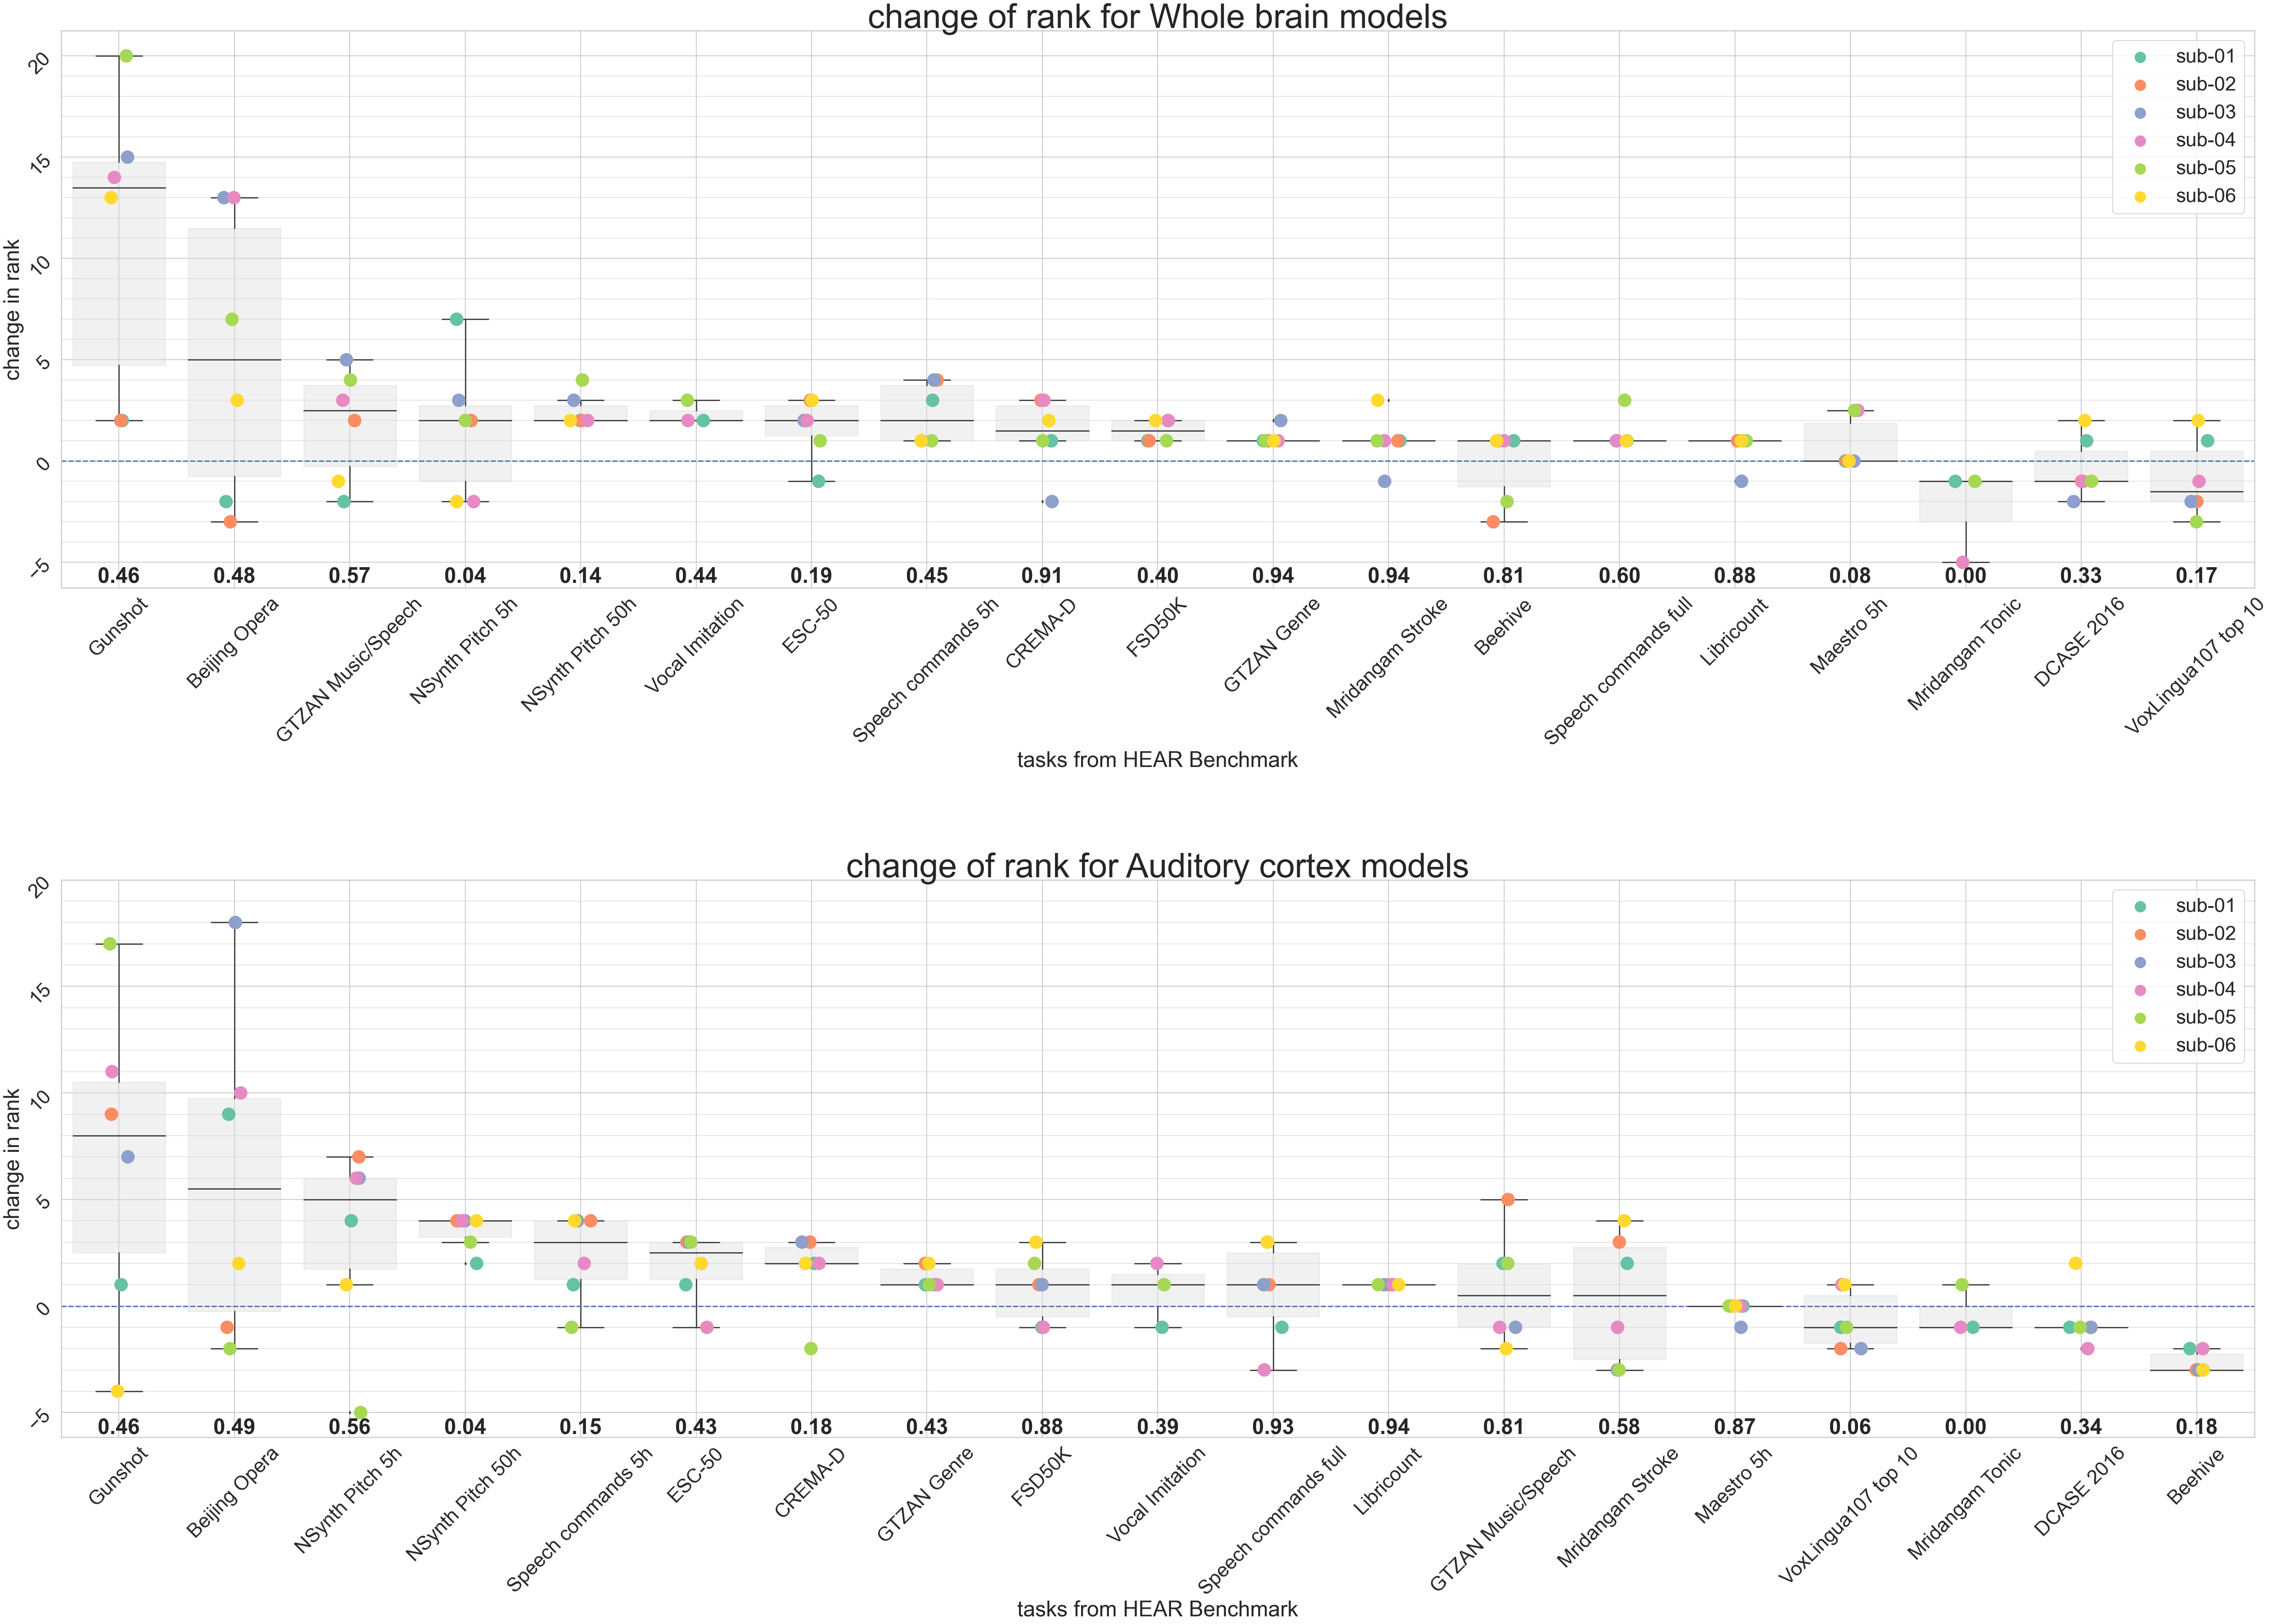

In [18]:
#mentionner l'accuracy moyenne a coté, et choisir quelques taches
categories = ['subject', 'atlas', 'finetune',
              'CREMA-D','Speech commands 5h', 'Speech commands full', 'Vocal Imitation','VoxLingua107 top 10',  
              'ESC-50', 'FSD50K', 'GTZAN Genre','GTZAN Music/Speech', 'Libricount', 
              'Beijing Opera', 'Mridangam Stroke','Mridangam Tonic', 'Beehive','Gunshot',
              'DCASE 2016', 'Maestro 5h', 'NSynth Pitch 50h', 'NSynth Pitch 5h']
df_acc = df_acc.reindex(columns=categories)
df_acc_stg = df_acc.loc[(df_acc['finetune']=='conv4') & (df_acc['atlas']=='STG')]
df_acc_stg = df_acc_stg[df_acc_stg.columns[3:]].median(axis='rows')
med_acc_stg = df_acc_stg.tolist()
df_acc_wb = df_acc.loc[(df_acc['finetune']=='conv4') & (df_acc['atlas']=='wholebrain')]
df_acc_wb = df_acc_wb[df_acc_wb.columns[3:]].median(axis='rows')
med_acc_wb = df_acc_wb.tolist()

df2 = df_rank_diff
df_ccn = df2.loc[(df2['finetune']=='conv4')]
df_ccn = df_ccn.reindex(columns=categories).reset_index()
df_ccn_wb = df_ccn.loc[df_ccn['atlas']=='wholebrain'].median(axis='rows').sort_values(ascending=False)
df_ccn_stg = df_ccn.loc[df_ccn['atlas']=='STG'].median(axis='rows').sort_values(ascending=False)
order_stg = df_ccn_stg.index
order_wb = df_ccn_wb.index

df_basis = pd.DataFrame([], columns=['subject', 'atlas'])
task = []
value = pd.Series(name='value', dtype=int)

for task_name in df_ccn.columns[4:]:
    df_basis = df_basis.append(df_ccn[['subject', 'atlas']]) 
    value = value.append(df_ccn[task_name])
    task += len(df_ccn[task_name]) * [task_name]
df_basis['task'] = task
df_basis['value']= value.values
df_result = df_basis.reset_index()
df_result.pop('index')

df_wb = df_result.loc[df_result['atlas']=='wholebrain']
df_stg = df_result.loc[df_result['atlas']=='STG']

df_wb["task"] = pd.Categorical(df_wb["task"], categories = order_wb)
df_stg["task"] = pd.Categorical(df_stg["task"], categories = order_stg)
df_wb.sort_values(by = "task")
df_stg.sort_values(by = "task")

#figure
sns.set_theme(context='poster', style='whitegrid', font_scale=2) 
fig = plt.figure(figsize=(70, 50), constrained_layout=True)
grid = fig.add_gridspec(ncols=1, nrows=2)

ax_wb = fig.add_subplot(grid[0,0])
ax_wb.set_title('change of rank for Whole brain models')
ax_stg = fig.add_subplot(grid[1,0])
ax_stg.set_title('change of rank for Auditory cortex models')

for (ax, df_a, med) in [(ax_wb, df_wb, med_acc_wb), (ax_stg, df_stg, med_acc_stg)]:
    sns.boxplot(data = df_a, x='task',  y='value', ax=ax, boxprops={'alpha': 0.4, 'color':'gainsboro'})
    sns.stripplot(data = df_a, x='task', y='value', hue="subject", ax=ax, palette="Set2", size=30)
    ax.legend(loc='best',markerscale=3)
    ax.tick_params(rotation = 45)
    ax.set_ylabel('change in rank')
    ax.set_xlabel('tasks from HEAR Benchmark')
    ax.axhline(0, ls='--')
    ax.title.set_size(75)
    
    major_ticks = np.arange(-5, 21, 5)
    minor_ticks = np.arange(-5, 21, 1)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1)
    
    med = ["%.2f" % val for val in med]
    for xtick in ax.get_xticks():
        ax.text(xtick,-6,med[xtick], 
            horizontalalignment='center', weight='semibold')
grid.update(hspace = 0.1)

savepath = '/home/maelle/Results/figures/heareval'
savename = 'fig_heareval_ccn2022.jpg'
plt.savefig(os.path.join(savepath, savename))
#fig.suptitle('difference of rank between the model Conv4 and the baseline (median accuracy of Conv4 above task label)')
